In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as patches
from matplotlib import pylab
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, matthews_corrcoef, accuracy_score
from sklearn.neural_network import MLPClassifier

In [2]:
# load sequence data
sequence_data = pd.read_csv('Waltz_Data_Filtered')

training_data = sequence_data.drop(['Classification', 'Sequence'], axis = 1)
target_data = sequence_data['Classification']

In [3]:
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(training_data, target_data, test_size = 0.2, random_state = 0)

# Set the parameters by cross-validation'
mlp_parameters = [{'activation' : ['identity', 'logistic', 'tanh'],
                  'learning_rate_init' : [0.1, 0.001, 0.0001, 0.00001],
                }]

classifier_mlp = GridSearchCV(MLPClassifier(max_iter = 1000), mlp_parameters, cv = 10, scoring='roc_auc')
classifier_mlp.fit(X_train, y_train)

C:\Users\Frederick Russo\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
C:\Users\Frederick Russo\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
C:\Users\Frederick Russo\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
C:\Users\Frederick Russo\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
C:\Users\Frederi

GridSearchCV(cv=10, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'activation': ['identity', 'logistic', 'tanh'], 'learning_rate_init': [0.1, 0.001, 0.0001, 1e-05]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [4]:
# save grid search results to variables, for plotting
mlp_activation = list(classifier_mlp.cv_results_['param_activation'])
mlp_learning_rate_init = list(classifier_mlp.cv_results_['param_learning_rate_init'])
mlp_results = classifier_mlp.cv_results_['mean_test_score']

In [5]:
# separate out results for each gamma value
mlp_activation_identity_results = []
mlp_activation_logistic_results = []
mlp_activation_tanh_results = []

lookup = {'identity' : mlp_activation_identity_results,
          'logistic' : mlp_activation_logistic_results,
          'tanh' : mlp_activation_tanh_results
         }

for i in range(0, len(mlp_activation)):
    activation_list = lookup[str(mlp_activation[i])]
    activation_list.append(mlp_results[i])

In [6]:
mlp_activation_identity_results

[0.77243651466746588,
 0.77534903559543122,
 0.80082734100945951,
 0.72624655569796837]

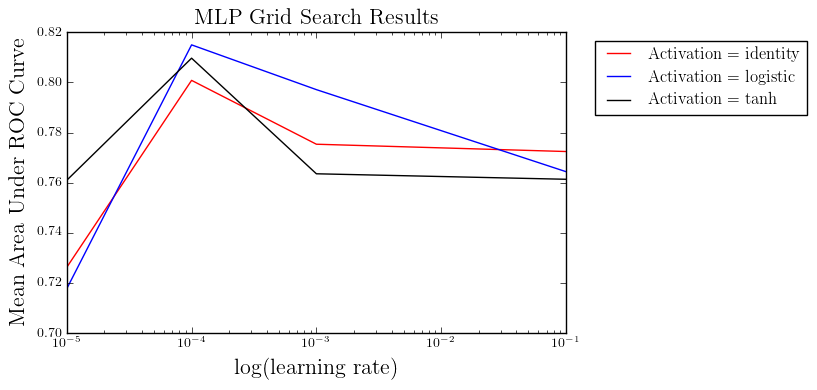

In [7]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'cm'

plt.semilogx(mlp_learning_rate_init[0:4], mlp_activation_identity_results, color = 'red')
plt.semilogx(mlp_learning_rate_init[0:4], mlp_activation_logistic_results, color = 'blue')
plt.semilogx(mlp_learning_rate_init[0:4], mlp_activation_tanh_results, color = 'black')

ax = plt.gca()
ax.set_title('MLP Grid Search Results', fontsize = 16)
ax.set_xlabel(r'$\log($learning rate$)', fontsize = 16)
ax.set_ylabel('Mean Area Under ROC Curve', fontsize = 16)

activation_identity = mlines.Line2D([], [], linestyle = '-', color = 'red', label = r'Activation = identity')
activation_logistic = mlines.Line2D([], [], linestyle = '-', color = 'blue', label = r'Activation = logistic')
activation_tanh = mlines.Line2D([], [], linestyle = '-', color = 'black', label = r'Activation = tanh')
plt.legend(handles = [activation_identity, activation_logistic, activation_tanh], loc = 'upper right', frameon = True, bbox_to_anchor=(1.5, 1))

plt.tight_layout()
plt.show()

In [8]:
# apply fitted SVM classifier with best hyperparameters to test data
y_score_pairs = classifier_mlp.best_estimator_.predict_proba(X_test)

# create array of probability scores for each hexapeptide
y_score_pos = []
for pair in y_score_pairs:
    y_score_pos.append(pair[1])

In [9]:
# calculate values needed for ROC curve
false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test, y_score_pos)

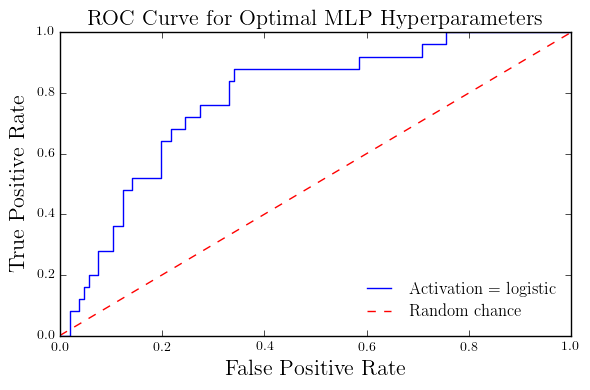

In [10]:
# plot ROC curve
plt.plot(false_pos_rate, true_pos_rate)
ax = plt.gca()
ax.set_title('ROC Curve for Optimal MLP Hyperparameters', fontsize = 16)
ax.set_xlabel('False Positive Rate', fontsize = 16)
ax.set_ylabel('True Positive Rate', fontsize = 16)

plt.plot(np.linspace(0, 1), np.linspace(0, 1), linestyle = '--', color = 'red')

ROC_curve = mlines.Line2D([], [], linestyle = '-', color = 'blue', label = r'Activation = ' + str(classifier_mlp.best_estimator_.activation))
rand_chance = mlines.Line2D([], [], linestyle = '--', color = 'red', label = r'Random chance')
plt.legend(handles = [ROC_curve, rand_chance], loc = 'lower right', frameon = False)

plt.tight_layout()
plt.show()

In [11]:
# find best probability threshold
ROC_line = list(zip(false_pos_rate, true_pos_rate))

# search for point on ROC line that is closest to point (0, 1)
best = (1, 0)
best_dist = 1
best_index = 0
for i in range(0, len(ROC_line)):
    new_dist = np.sqrt((0 - ROC_line[i][0]) + (1 - ROC_line[i][1]))
    if (new_dist < best_dist):
        best = ROC_line[i]
        best_index = i

# find best probability threshold
best_theshold = thresholds[best_index]
print('best probability threshold =', best_theshold)

best probability threshold = 0.147417464685


In [12]:
y_test_predicted = []
for probability in y_score_pos:
    if (probability >= best_theshold):
        y_test_predicted.append(1)
    else:
        y_test_predicted.append(0)

In [13]:
matthews_corrcoef(y_test, y_test_predicted)

0.36574065275402967

In [14]:
matthews_corrcoef(y_test, classifier_mlp.best_estimator_.predict(X_test))

0.11951896478036046

In [15]:
accuracy_score(y_test, classifier_mlp.best_estimator_.predict(X_test))

0.79389312977099236